In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

%matplotlib inline

In [2]:
import networkx as nx

In [3]:
from os.path import join

In [4]:
df = pd.read_csv("../data/crime.csv", parse_dates=["date"], encoding="latin")

In [5]:
df.head()

year       date        lat         lon  \
0  2015 2015-10-12  25.617672 -100.259318   
1  2015 2015-10-02  25.632075 -100.286088   
2  2015 2015-10-01  25.675784 -100.475788   
3  2015 2015-09-24  25.657586 -100.322029   
4  2015 2015-09-24  25.683207 -100.305650   

                                    news  cassualties  \
0          Persiguen y ejecutan a hombre          1.0   
1  Ejecutan a uno en plaza en Garza Sada          1.0   
2           Lo ejecutan frente a su casa          1.0   
3             Lo esperan para ejecutarlo          1.0   
4  Matan a 2 clientes en ataque 13 a bar          2.0   

                                                 url  object_id  postal_code  \
0  http://www.elnorte.com/aplicaciones/articulo/d...      35483      64878.0   
1  http://www.elnorte.com/aplicaciones/articulo/d...      35424      64788.0   
2  http://www.elnorte.com/aplicaciones/articulo/d...      36310      66257.0   
3  http://www.elnorte.com/aplicaciones/articulo/d...      35376      64720.0   
4  http://www.elnorte.com/aplicaciones/articulo/d...      34955      64000.0   

         mun_name                 neighborhood_name neighborhood_type  \
0       MONTERREY                EJIDAL LOS REMATES           COLONIA   
1       MONTERREY             REVOLUCION PROLETARIA           COLONIA   
2  SANTA CATARINA  HDA SANTA CATARINA (FOMERREY 29)           COLONIA   
3       MONTERREY                     INDEPENDENCIA   FRACCIONAMIENTO   
4       MONTERREY               CENTRO DE MONTERREY           COLONIA   

       area  
0  0.000042  
1  0.000009  
2  0.000023  
3  0.000222  
4  0.000717

In [6]:
municipios = pd.read_csv("../data/municipios.txt", encoding = "latin", header = None, names = ["name"])

In [7]:
municipios = municipios.name.tolist()

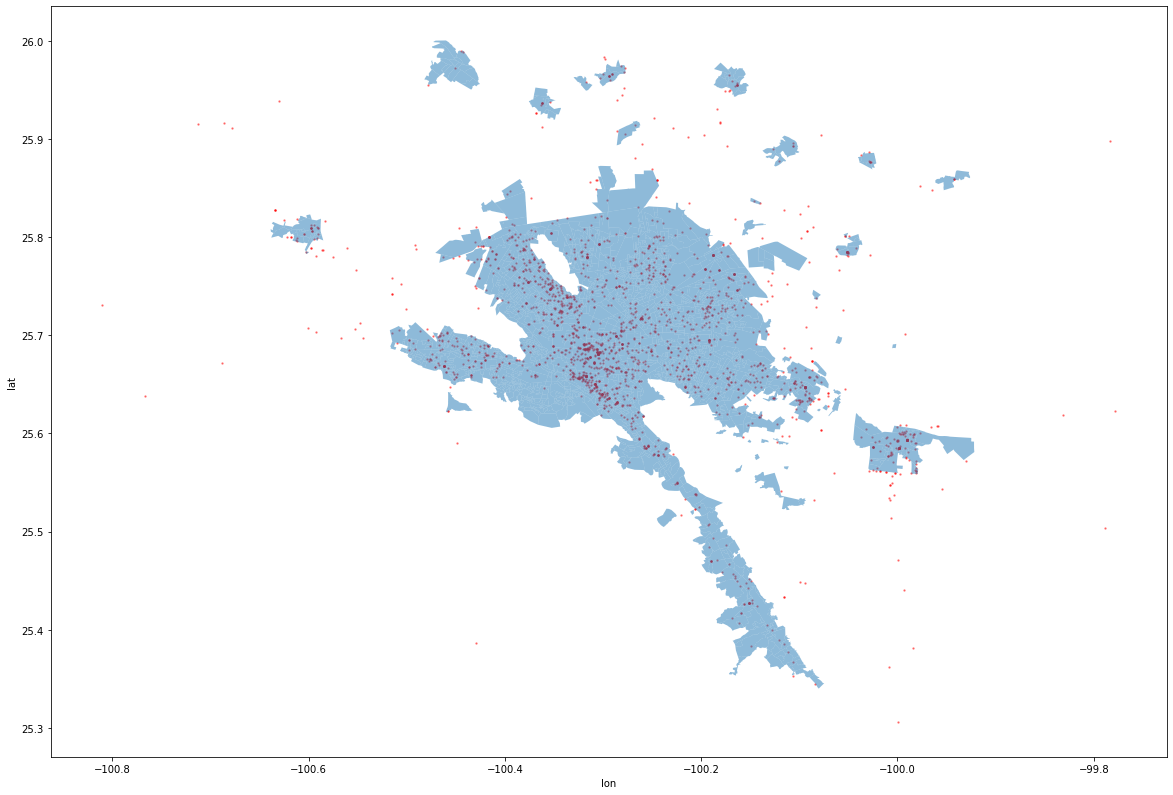

In [8]:
PATH = "/home/dianae/Workspace/crimenNL/shape"

fp = join(PATH, 'nuevo_leon.shp')

map_df = gpd.read_file(fp, encoding = 'latin')
map_df = map_df[map_df['MUN_NAME'].isin(municipios)]

fig, ax = plt.subplots(figsize=(20, 20))
scatter = df.plot.scatter(x='lon', y='lat', ax=ax, alpha=0.4, c='Red', s = 2)

map_df.plot(ax=ax, alpha=0.5)

In [9]:
vecinos =  pd.read_csv("../data/adjacent_neighborhoods.csv")

In [10]:
map_df["CENTROID"] = map_df.geometry.centroid.apply(lambda p: (p.x, p.y))

In [11]:
map_df["WITH_EVENT"] = map_df.OBJECTID.apply(lambda x: x in df.object_id.tolist())

In [12]:
nodeData = map_df[["OBJECTID", "SETT_NAME", "POSTALCODE", "MUN_NAME", 
                   "SETT_TYPE", "CENTROID", "WITH_EVENT"]].set_index("OBJECTID").to_dict('index')

### El df de vecinos tiene que filtrarse porque quitamos municipios

In [13]:
vecinos = vecinos[vecinos['source'].isin(map_df.OBJECTID.tolist()) & vecinos['target'].isin(map_df.OBJECTID.tolist())]       

In [14]:
G = nx.from_pandas_edgelist(vecinos)
G.add_nodes_from(map_df.OBJECTID)
nx.set_node_attributes(G, nodeData)

/home/dianae/Workspace/crimenNL/vcrime/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


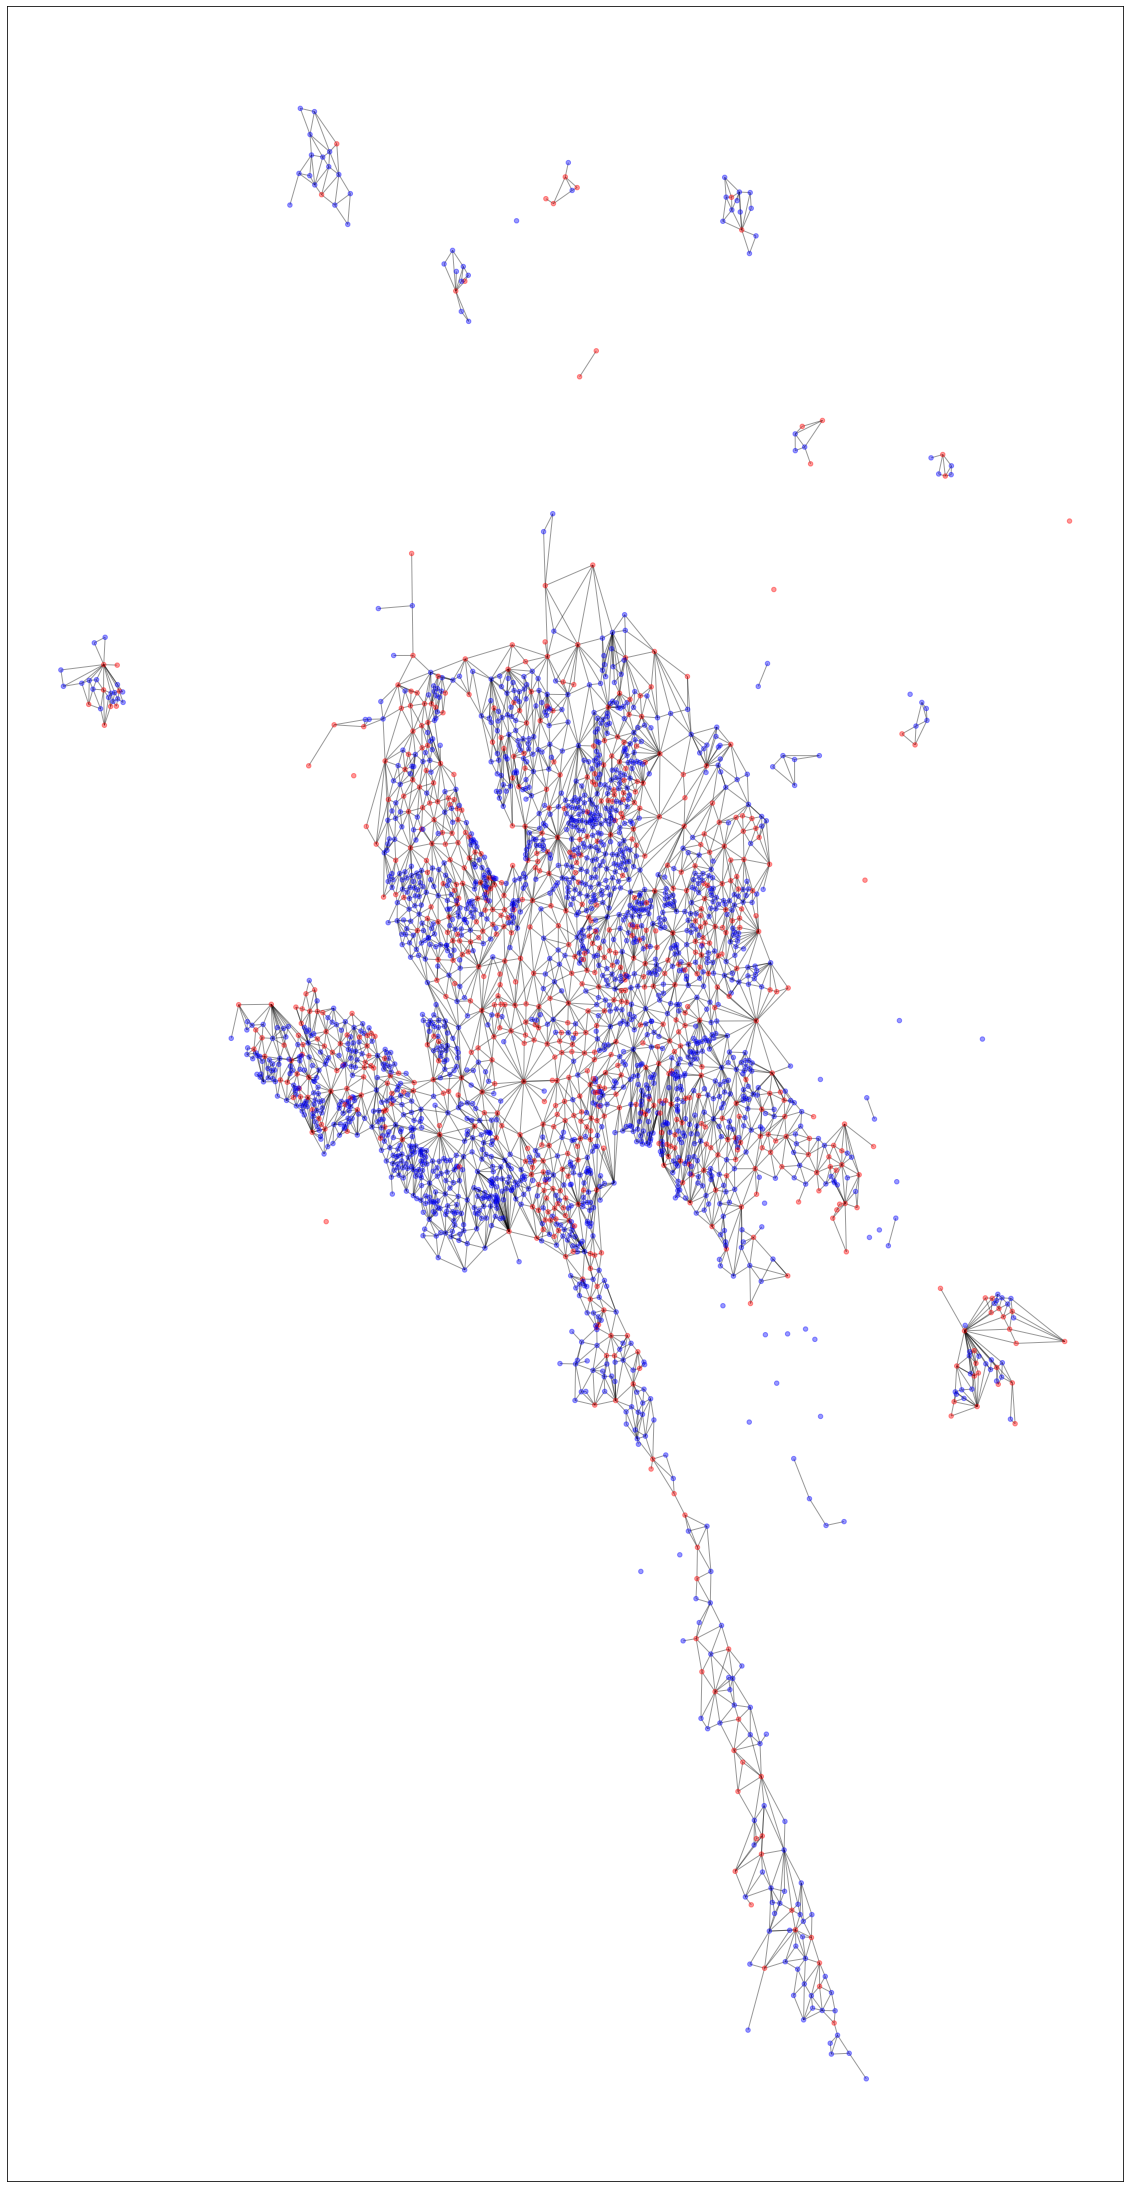

In [15]:
plt.figure(figsize=(20, 40))
pos = nx.get_node_attributes(G, "CENTROID")
color = ["red" if val else "blue" for key, val in nx.get_node_attributes(G, "WITH_EVENT").items()]
nx.draw_networkx(G, pos = pos, node_color = color, with_labels = False, node_size = 20, alpha = 0.4)

In [16]:
df_cytoscape = map_df.loc[:, ['OBJECTID', 'POSTALCODE', 'MUN_NAME', 'SETT_NAME',
       'SETT_TYPE', "Shape_Area", 'WITH_EVENT']]
df_cytoscape["x_centroid"] =  round(map_df.geometry.centroid.x, 3)
df_cytoscape["y_centroid"] =  round(map_df.geometry.centroid.y, 3)
df_cytoscape.columns = ['object_id', 'postal_code', 'mun_name', 'neighborhood_name',
       'neighborhood_type', "area", "with_event", "x_centroid", "y_centroid"]
df_cytoscape.to_csv("../data/map_df_all.csv", encoding = "utf-8")

In [16]:
nodes_with_events = [n for n,v in G.nodes(data=True) if v['WITH_EVENT'] == True]

In [17]:
crimeG = G.subgraph(nodes_with_events).copy()

In [18]:
crimeG.add_nodes_from(G.nodes(data=True))

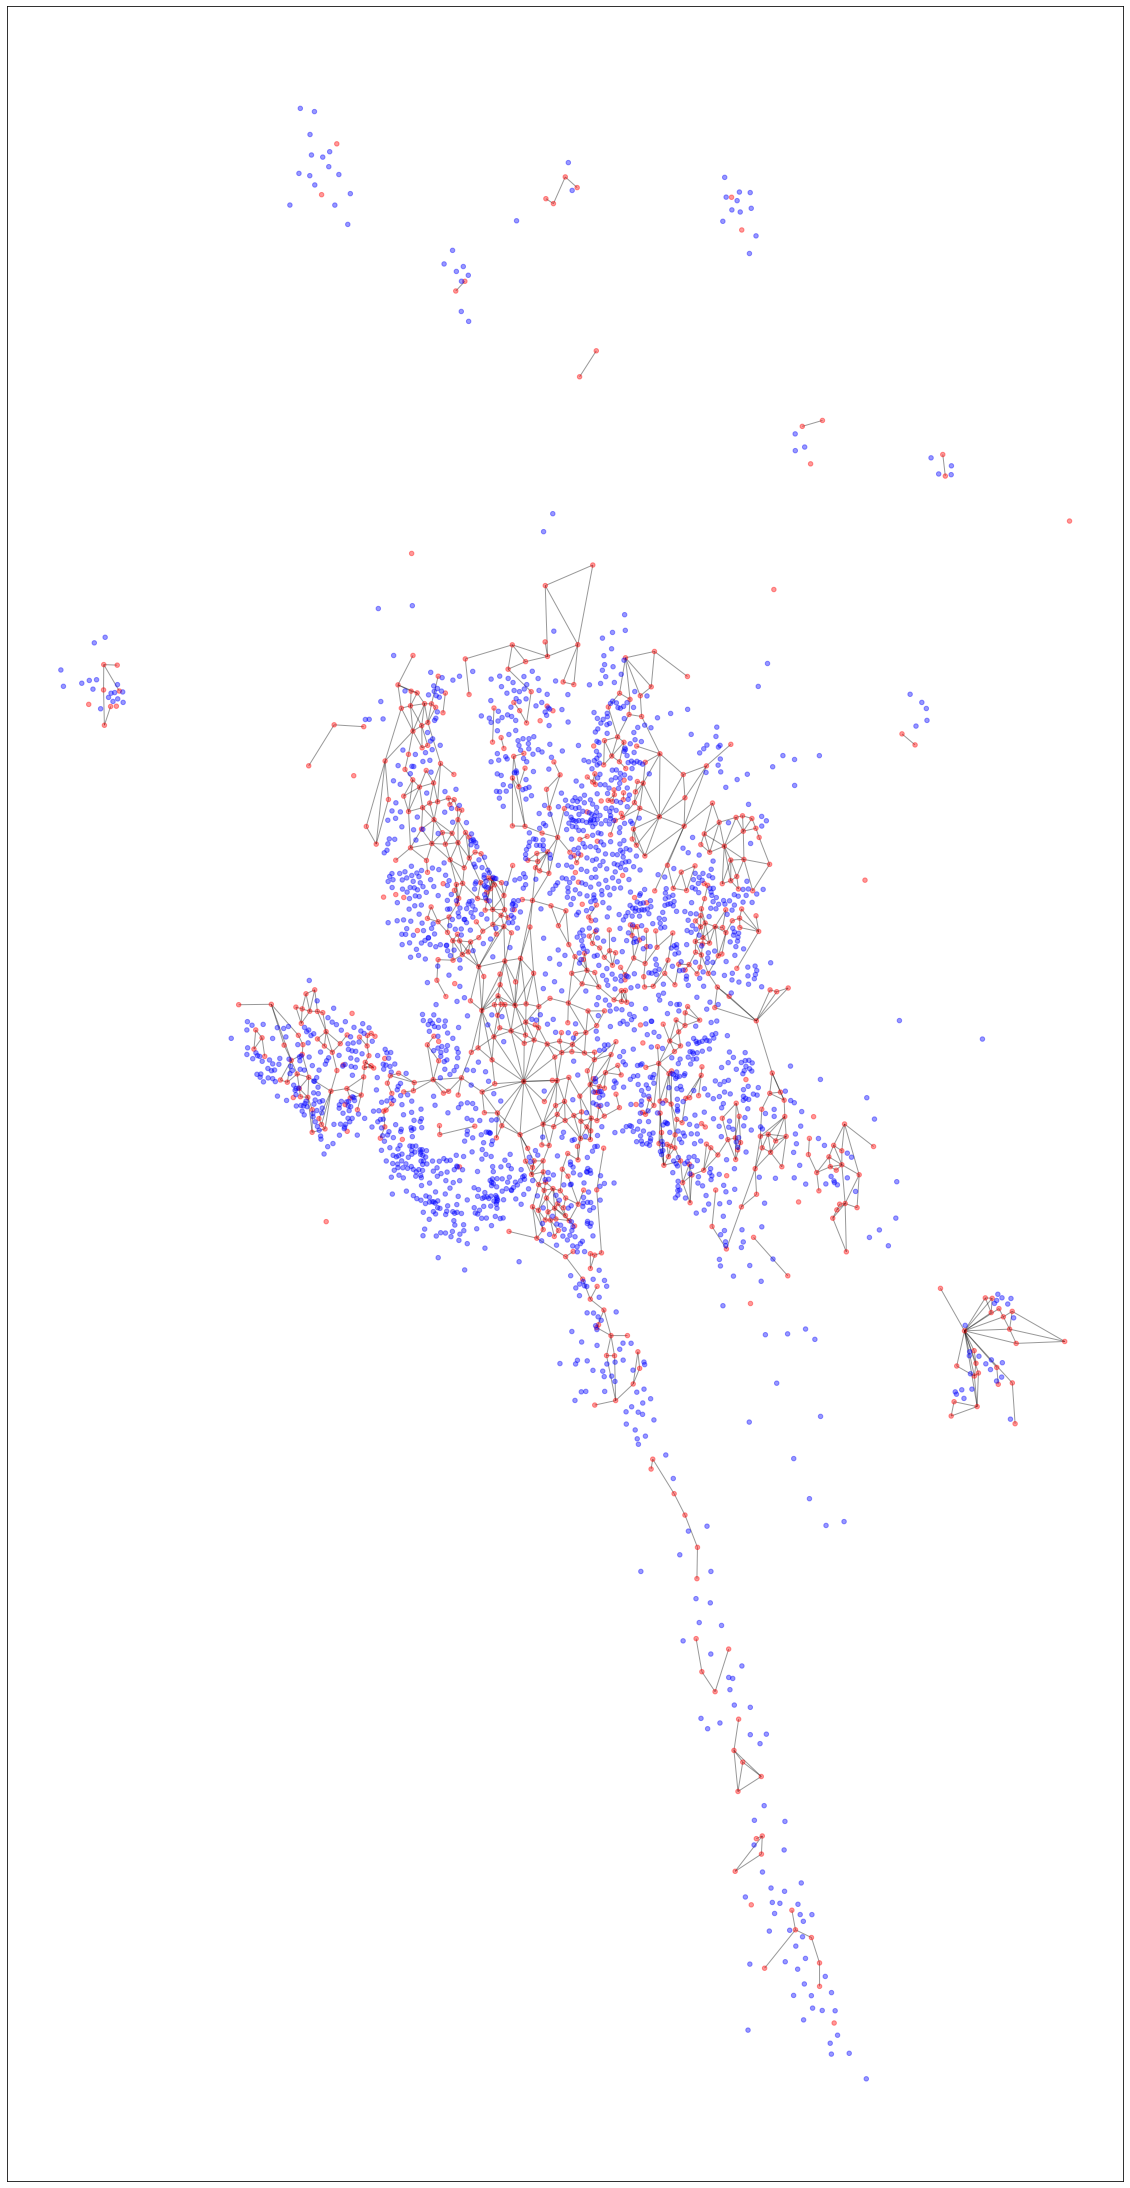

In [19]:
plt.figure(figsize=(20, 40))
pos = nx.get_node_attributes(crimeG, "CENTROID")
color = ["red" if val else "blue" for key, val in nx.get_node_attributes(crimeG, "WITH_EVENT").items()]
nx.draw_networkx(crimeG, pos = pos, node_color = color, with_labels = False, node_size = 20, alpha = 0.4)

### Ahora separemos la red por fechas

In [20]:
df.set_index(["object_id", "date"], inplace=True)
level_values = df.index.get_level_values

In [21]:
df_agg = df.groupby([level_values(0)] + [pd.Grouper(freq='W', closed='left', level=-1)]).agg(
    events =  ("cassualties", "count"),
    cassualties = ("cassualties", "sum"),
    lat = ("lat", "first"),
    lon = ("lon", "first"),
    postal_code = ("postal_code", "first"),
    mun_name = ("mun_name", "first"),
    neighborhood_name = ("neighborhood_name", "first"),
    neighborhood_type = ("neighborhood_type", "first")
)

In [22]:
semesters = pd.date_range("2010-12-31", max(level_values(1)), freq='6M')

In [23]:
df_agg.sort_index(level=['object_id','date'], inplace=True, ascending=[True, True])
idx = pd.IndexSlice

In [24]:
df_filter = df_agg.loc[idx[:, :semesters[1]], :]

In [25]:
def get_crime_network_from_time_window(df, map_df, G, start, end, folder):
    ### function to get networks with crime neighborhoods linked by a start and end time frame. 
    ### df is a multi index data frame. Index 0: Locations. Index 1: Time
    ### map_df has the neighborhood info
    ### G is the network from all adjacent neighborhoods
    idx = pd.IndexSlice
    df_filter = df.loc[idx[:, start:end], :]
    df_filter.to_csv("../data/" + str(folder) + "/crime_network_" + 
        start.strftime('%Y-%m-%d') + "_" + end.strftime('%Y-%m-%d')  + "_data.csv", sep = "\t", index = True)
    map_df["WITH_EVENT"] = map_df.OBJECTID.apply(lambda x: x in df_filter.index.get_level_values(0).tolist())    
    nodeData = map_df[["OBJECTID", "WITH_EVENT"]].set_index("OBJECTID").to_dict('index')
    nx.set_node_attributes(G, nodeData)
    nodes_with_events = [n for n,v in G.nodes(data=True) if v['WITH_EVENT'] == True]
    crimeG = G.subgraph(nodes_with_events).copy()
    crimeG.add_nodes_from(G.nodes(data=True))
    nx.to_pandas_edgelist(crimeG).to_csv("../data/" + str(folder) + "/crime_network_" + 
        start.strftime('%Y-%m-%d') + "_" + end.strftime('%Y-%m-%d')  + "_edges.csv", sep = "\t", index = False)
    df_cytoscape = map_df.loc[:, ['OBJECTID', 'POSTALCODE', 'MUN_NAME', 'SETT_NAME',
        'SETT_TYPE', "Shape_Area", 'WITH_EVENT']]
    df_cytoscape["x_centroid"] =  round(map_df.geometry.centroid.x, 3)
    df_cytoscape["y_centroid"] =  round(map_df.geometry.centroid.y, 3)
    df_cytoscape.columns = ['object_id', 'postal_code', 'mun_name', 'neighborhood_name',
        'neighborhood_type', "area", "with_event", "x_centroid", "y_centroid"]
    df_cytoscape.to_csv("../data/" + str(folder) + "/crime_network_" + start.strftime('%Y-%m-%d') + 
        "_" + end.strftime('%Y-%m-%d')  + "_nodes.csv", sep = "\t", index = False)

    return(crimeG)

In [26]:
networks  = []
for i in range(len(semesters)-1):
    g = get_crime_network_from_time_window(df_agg, map_df, G, semesters[i], semesters[i+1], "semesters")
    networks.append(g)
g = get_crime_network_from_time_window(df_agg, map_df, G, semesters[-1], pd.to_datetime("2018-06-30"), "semesters")
networks.append(g)

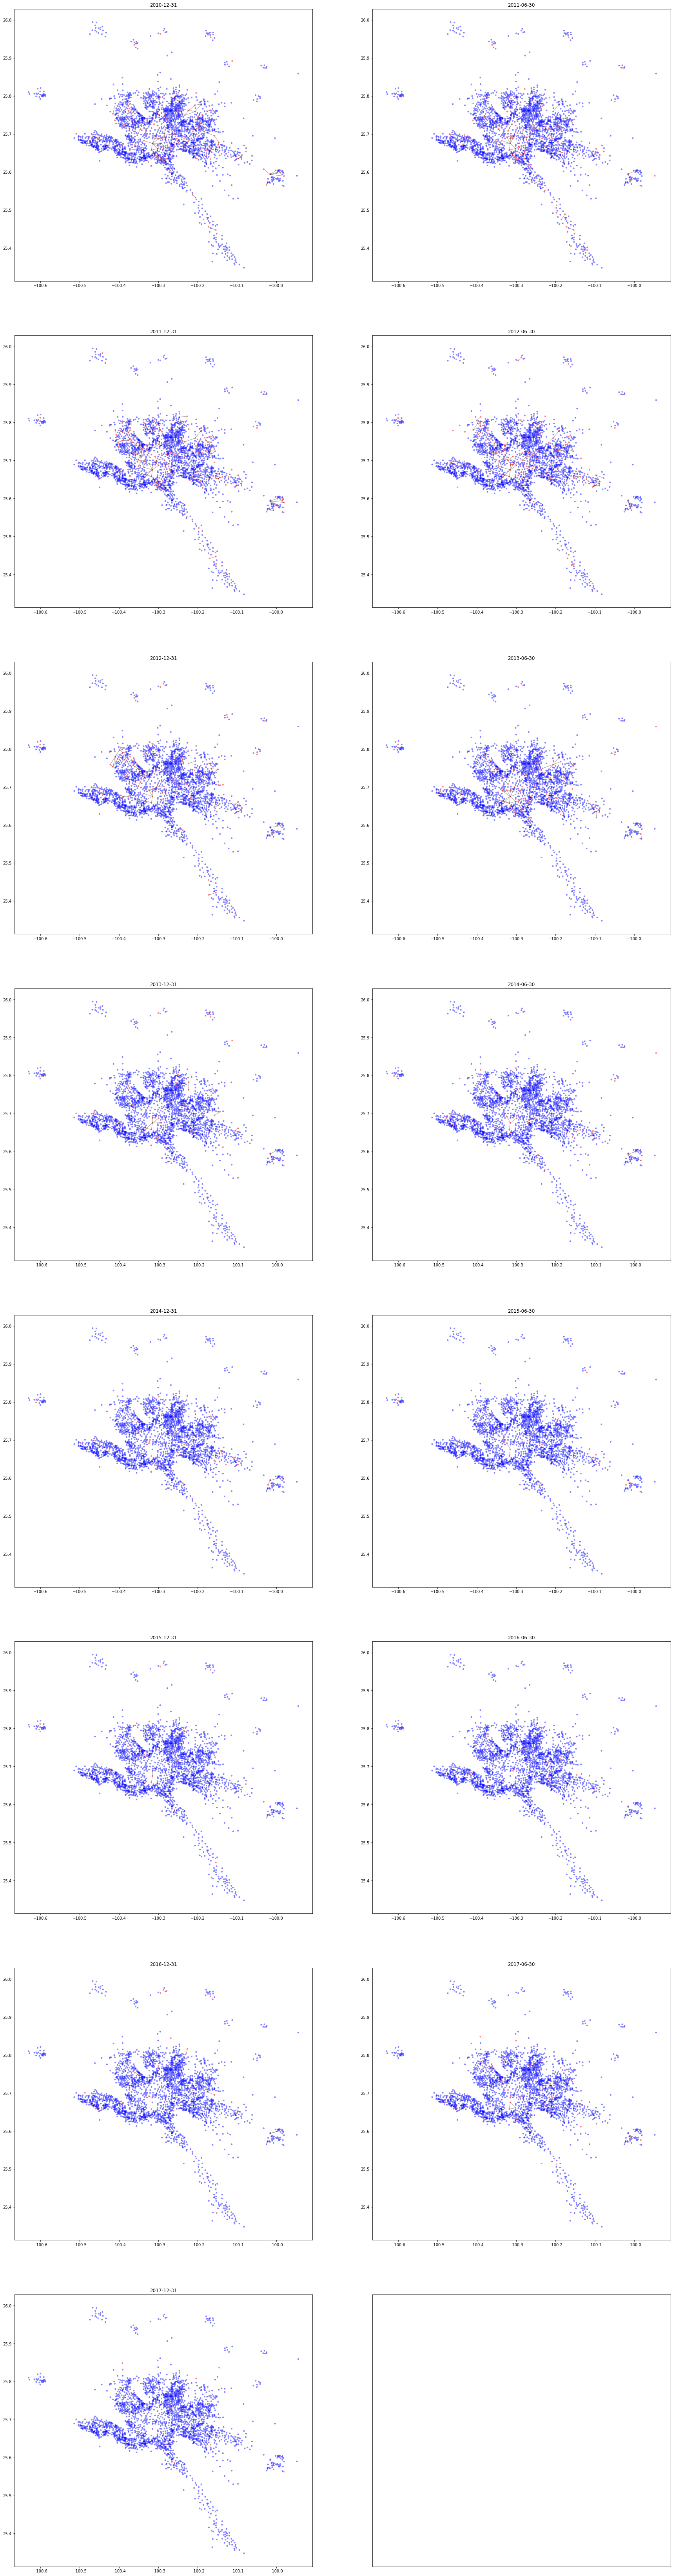

In [42]:
fig, ax = plt.subplots(nrows = int(len(networks)/2+1), ncols= 2, figsize=(30, 120));
ax = ax.flatten()
pos = nx.get_node_attributes(networks[0], "CENTROID")
for i in range(len(networks)):
    ax[i].set_title(semesters[i].strftime('%Y-%m-%d'))
    color = ["red" if val else "blue" for key, val in nx.get_node_attributes(networks[i], "WITH_EVENT").items()]
    nx.draw_networkx(networks[i], ax = ax[i], pos = pos, node_color = color, 
                     with_labels = False, node_size = 10, alpha = 0.4)
plt.show()

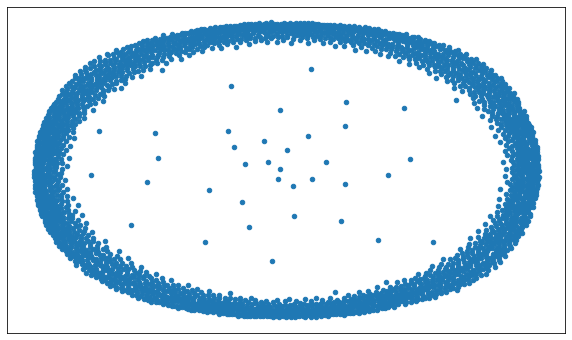

In [43]:
inter = nx.intersection_all(networks)
fig, ax = plt.subplots(1, 1, figsize=(10, 6));
nx.draw_networkx(inter, ax=ax, with_labels = False, node_size = 20)

/home/dianae/Workspace/crimenNL/vcrime/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


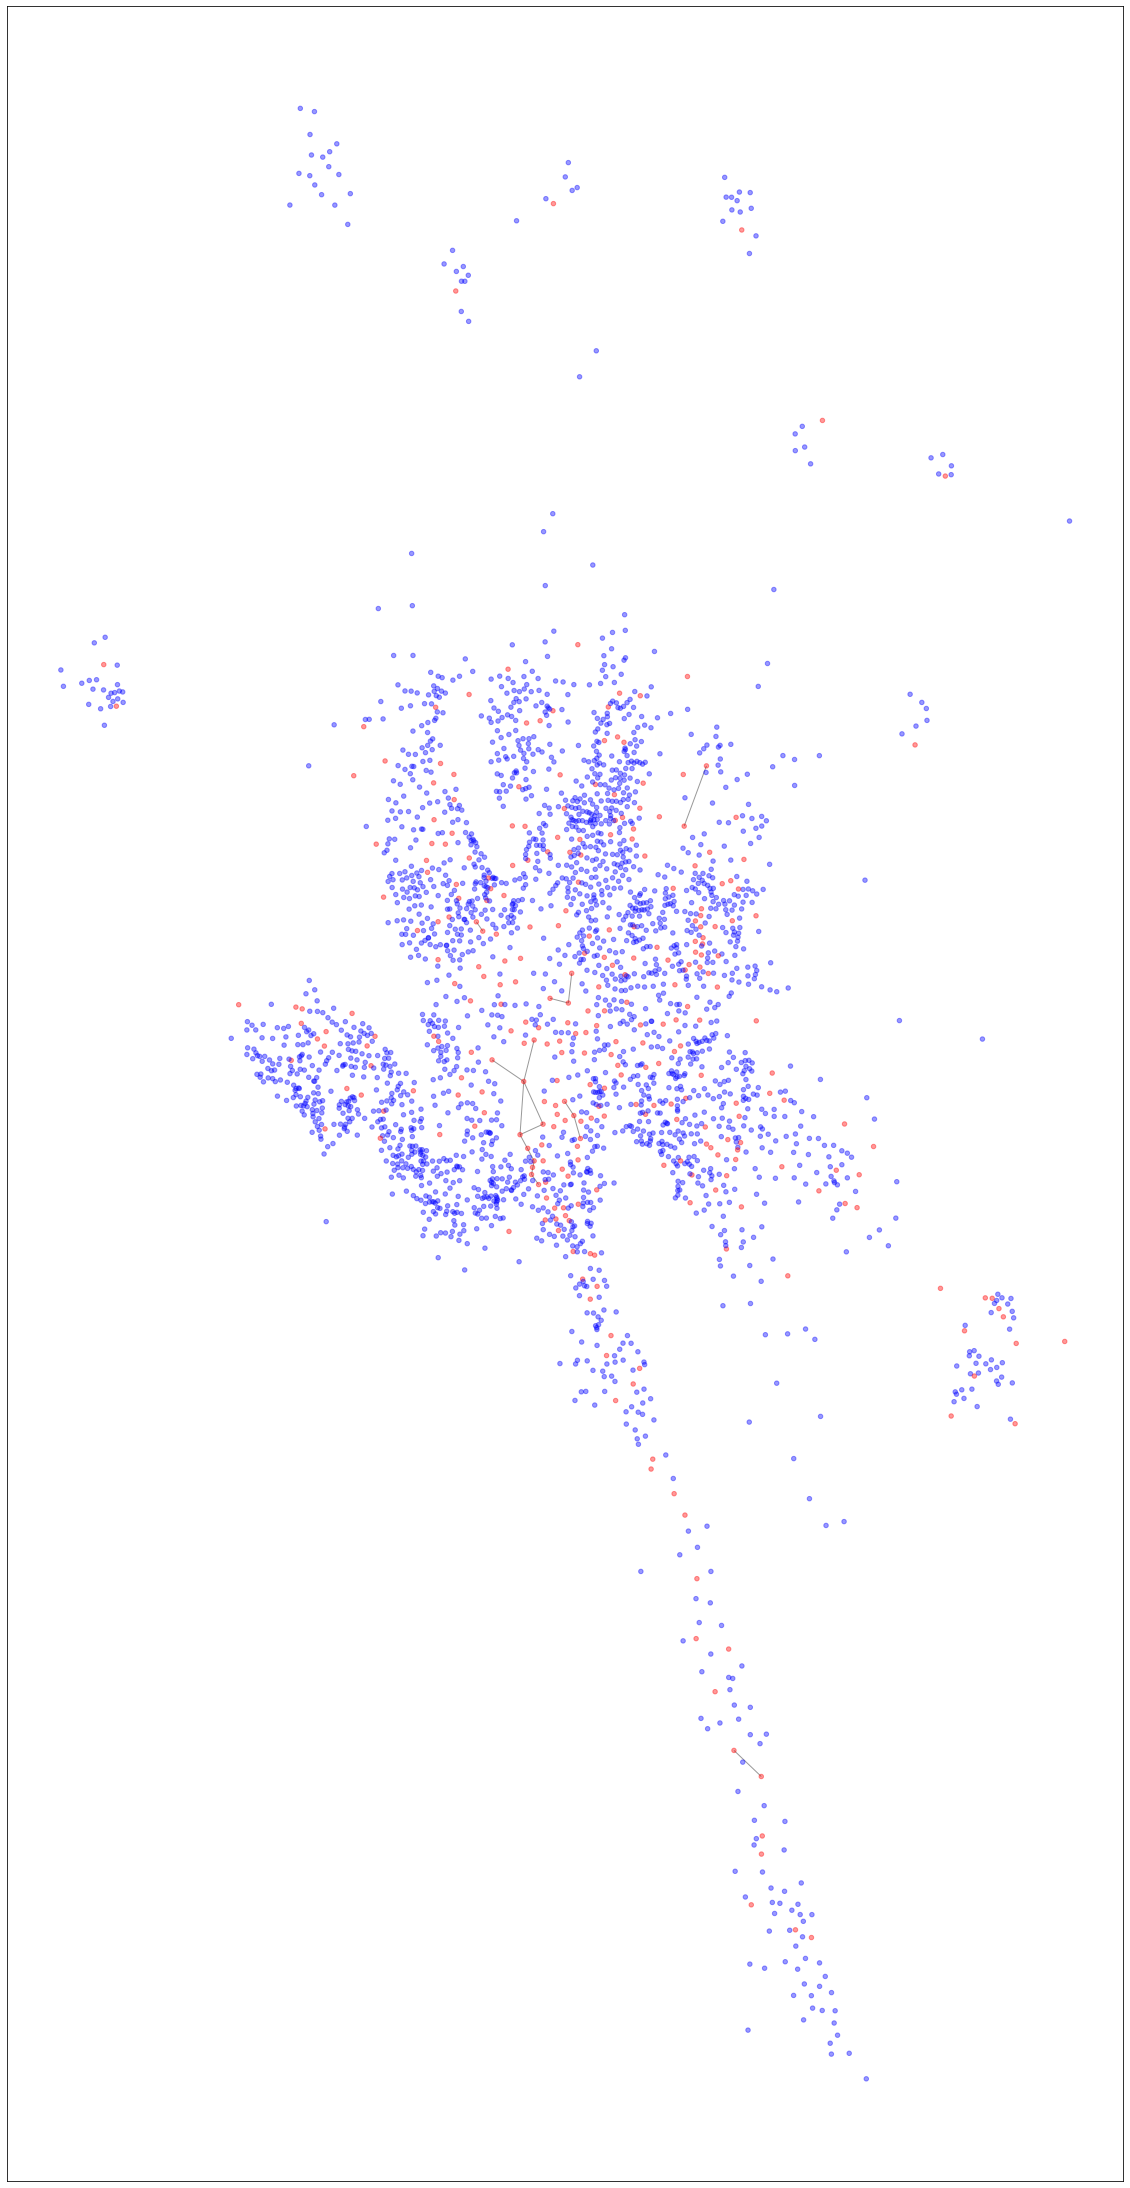

In [47]:
intersection_2011 = inter = nx.intersection(networks[0], networks[1])
events_2011a = nx.get_node_attributes(networks[0], "WITH_EVENT")
events_2011b = nx.get_node_attributes(networks[1], "WITH_EVENT")
color = ["red" if (events_2011a[key] == True or events_2011b[key] == True) else "blue" 
         for key in events_2011a.keys()]
plt.figure(figsize=(20, 40))
nx.draw_networkx(intersection_2011, pos = pos, node_color = color, 
                     with_labels = False, node_size = 20, alpha = 0.4)
plt.show()

In [50]:
def get_networks_intersection(network1, network2):
    intersection = nx.intersection(network1, network2)
    events1 = nx.get_node_attributes(network1, "WITH_EVENT")
    events2 = nx.get_node_attributes(network2, "WITH_EVENT")
    color = ["red" if (events1[key] == True or events2[key] == True) else "blue" 
         for key in events2.keys()]
    return intersection, color

### Interseccion 2012

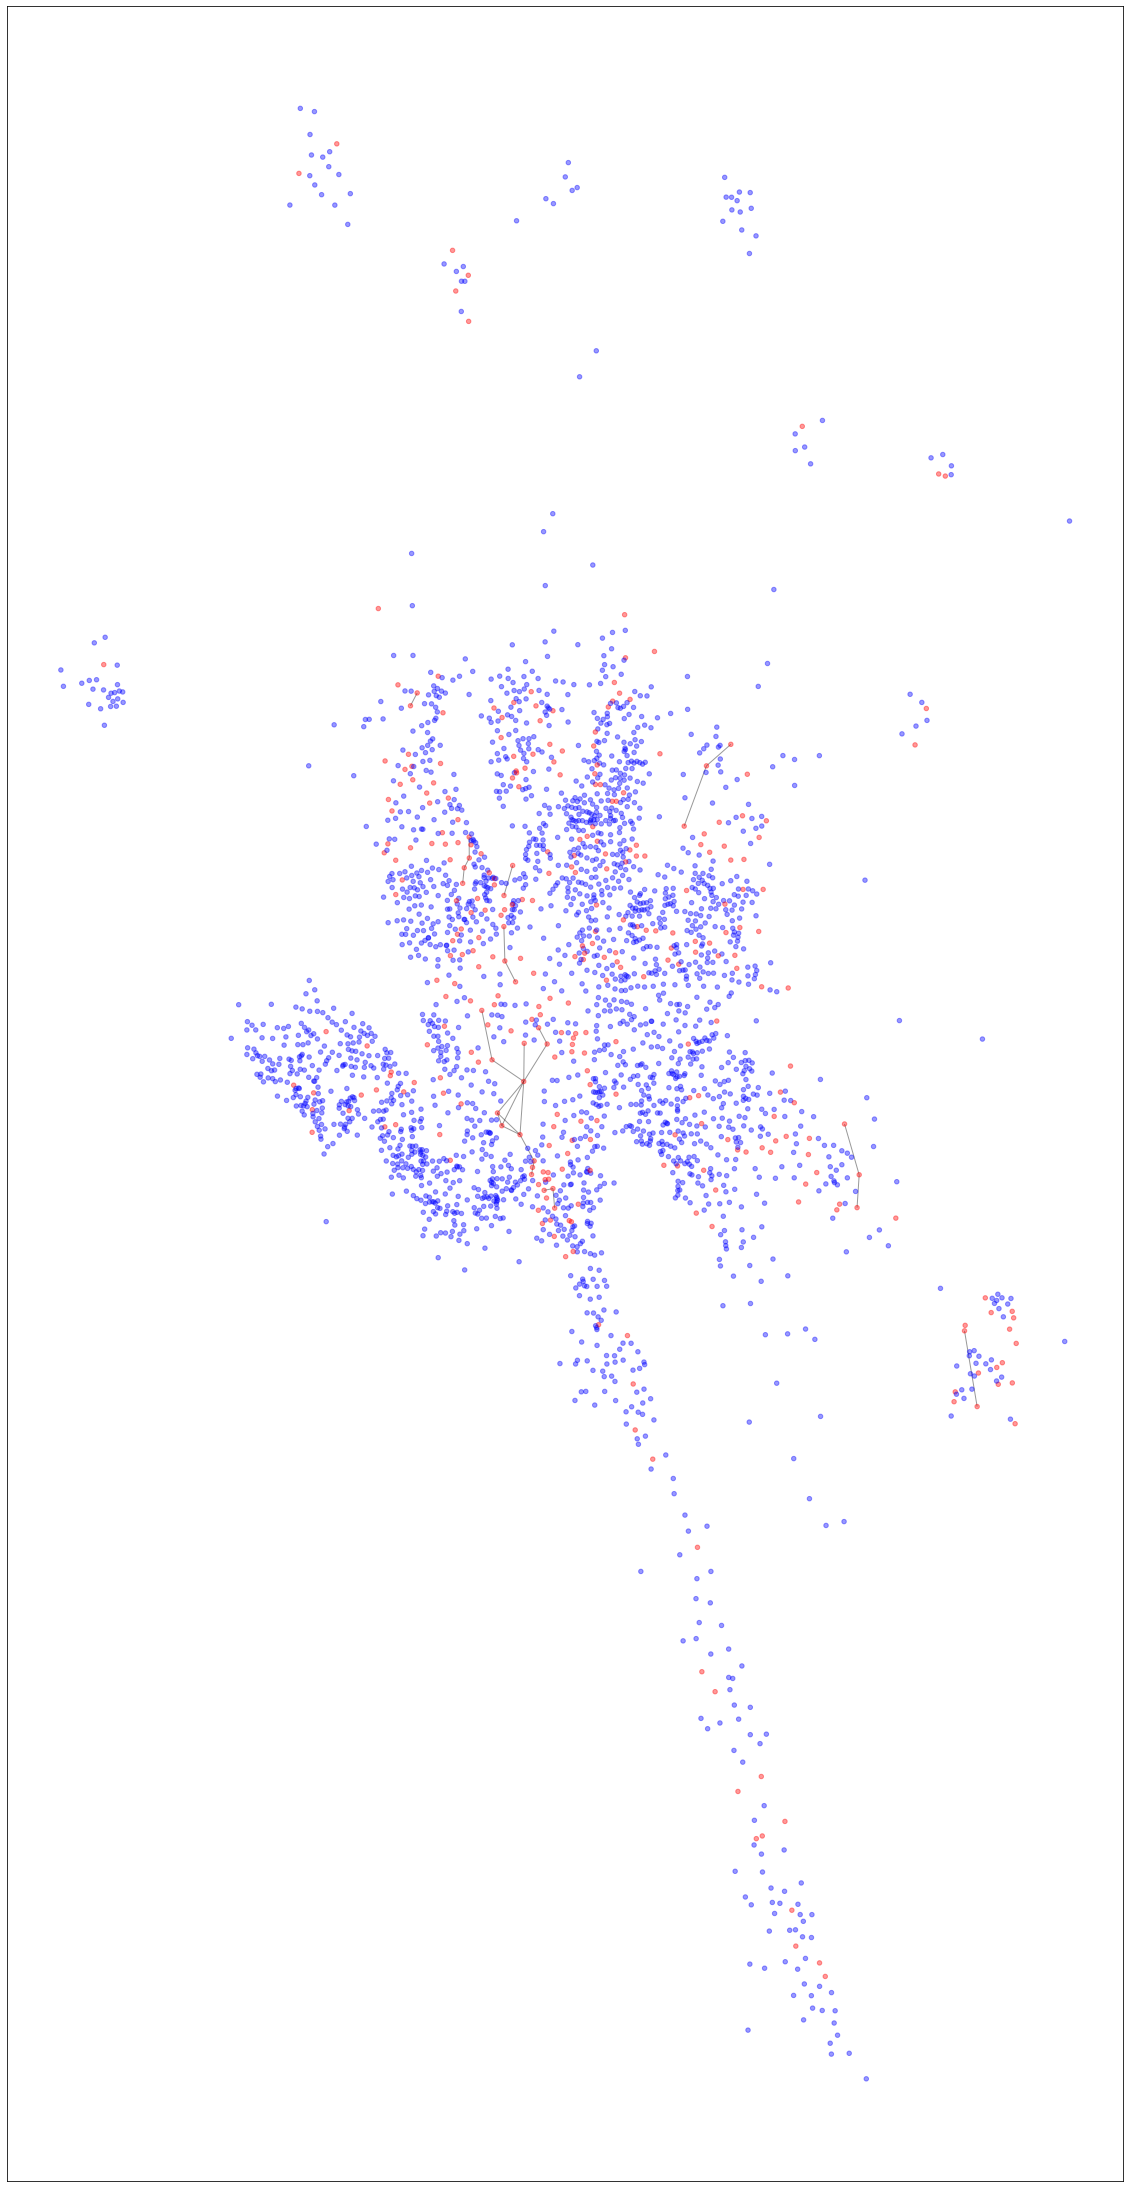

In [51]:
intersection, color2 = get_networks_intersection(networks[2], networks[3])
plt.figure(figsize=(20, 40))
nx.draw_networkx(intersection, pos = pos, node_color = color2, 
                     with_labels = False, node_size = 20, alpha = 0.4)
plt.show()

### Intersección 2013

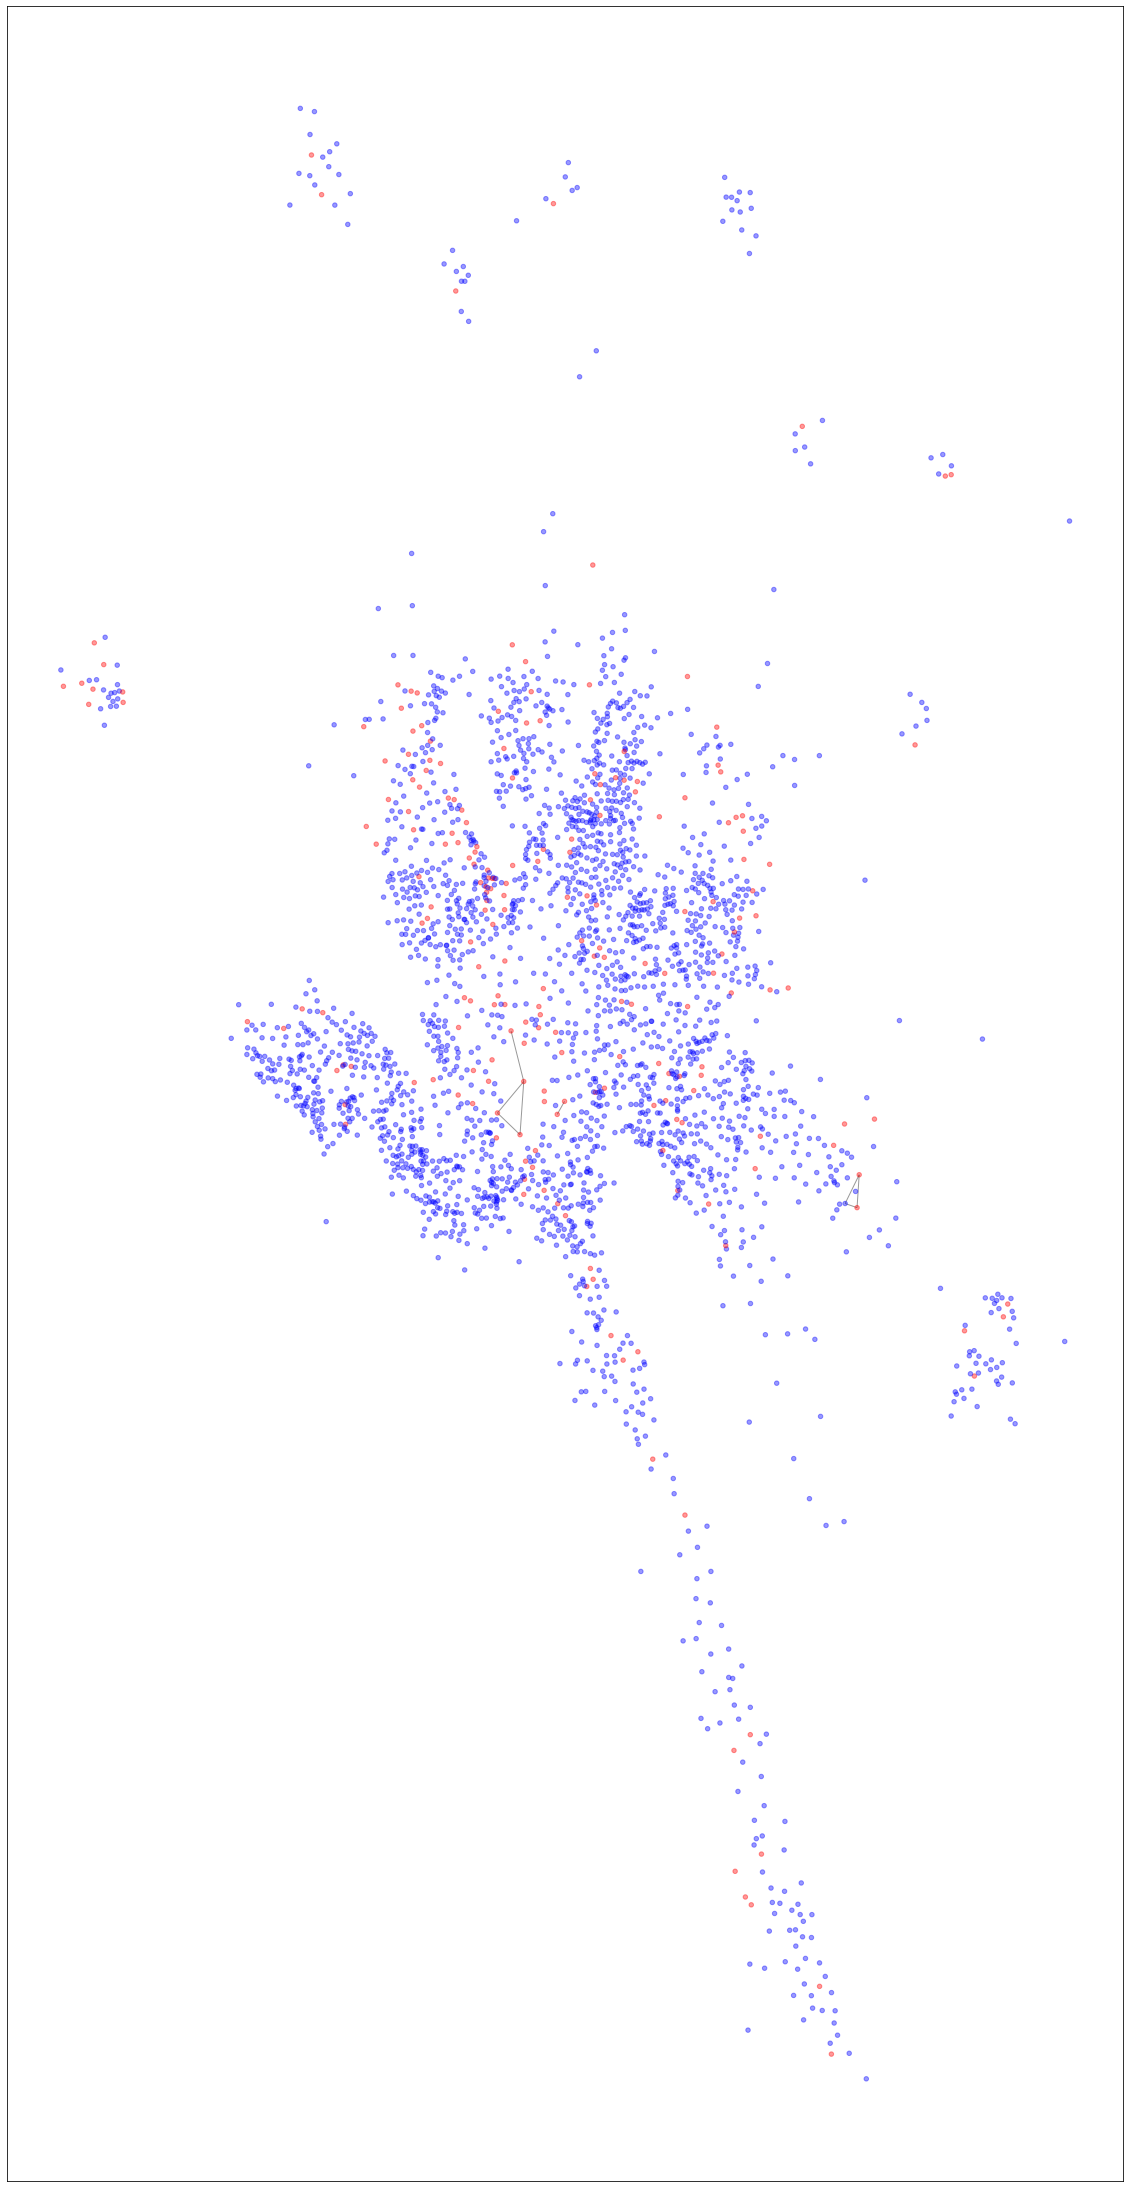

In [52]:
intersection, color2 = get_networks_intersection(networks[4], networks[5])
plt.figure(figsize=(20, 40))
nx.draw_networkx(intersection, pos = pos, node_color = color2, 
                     with_labels = False, node_size = 20, alpha = 0.4)
plt.show()

### Intersección 2014

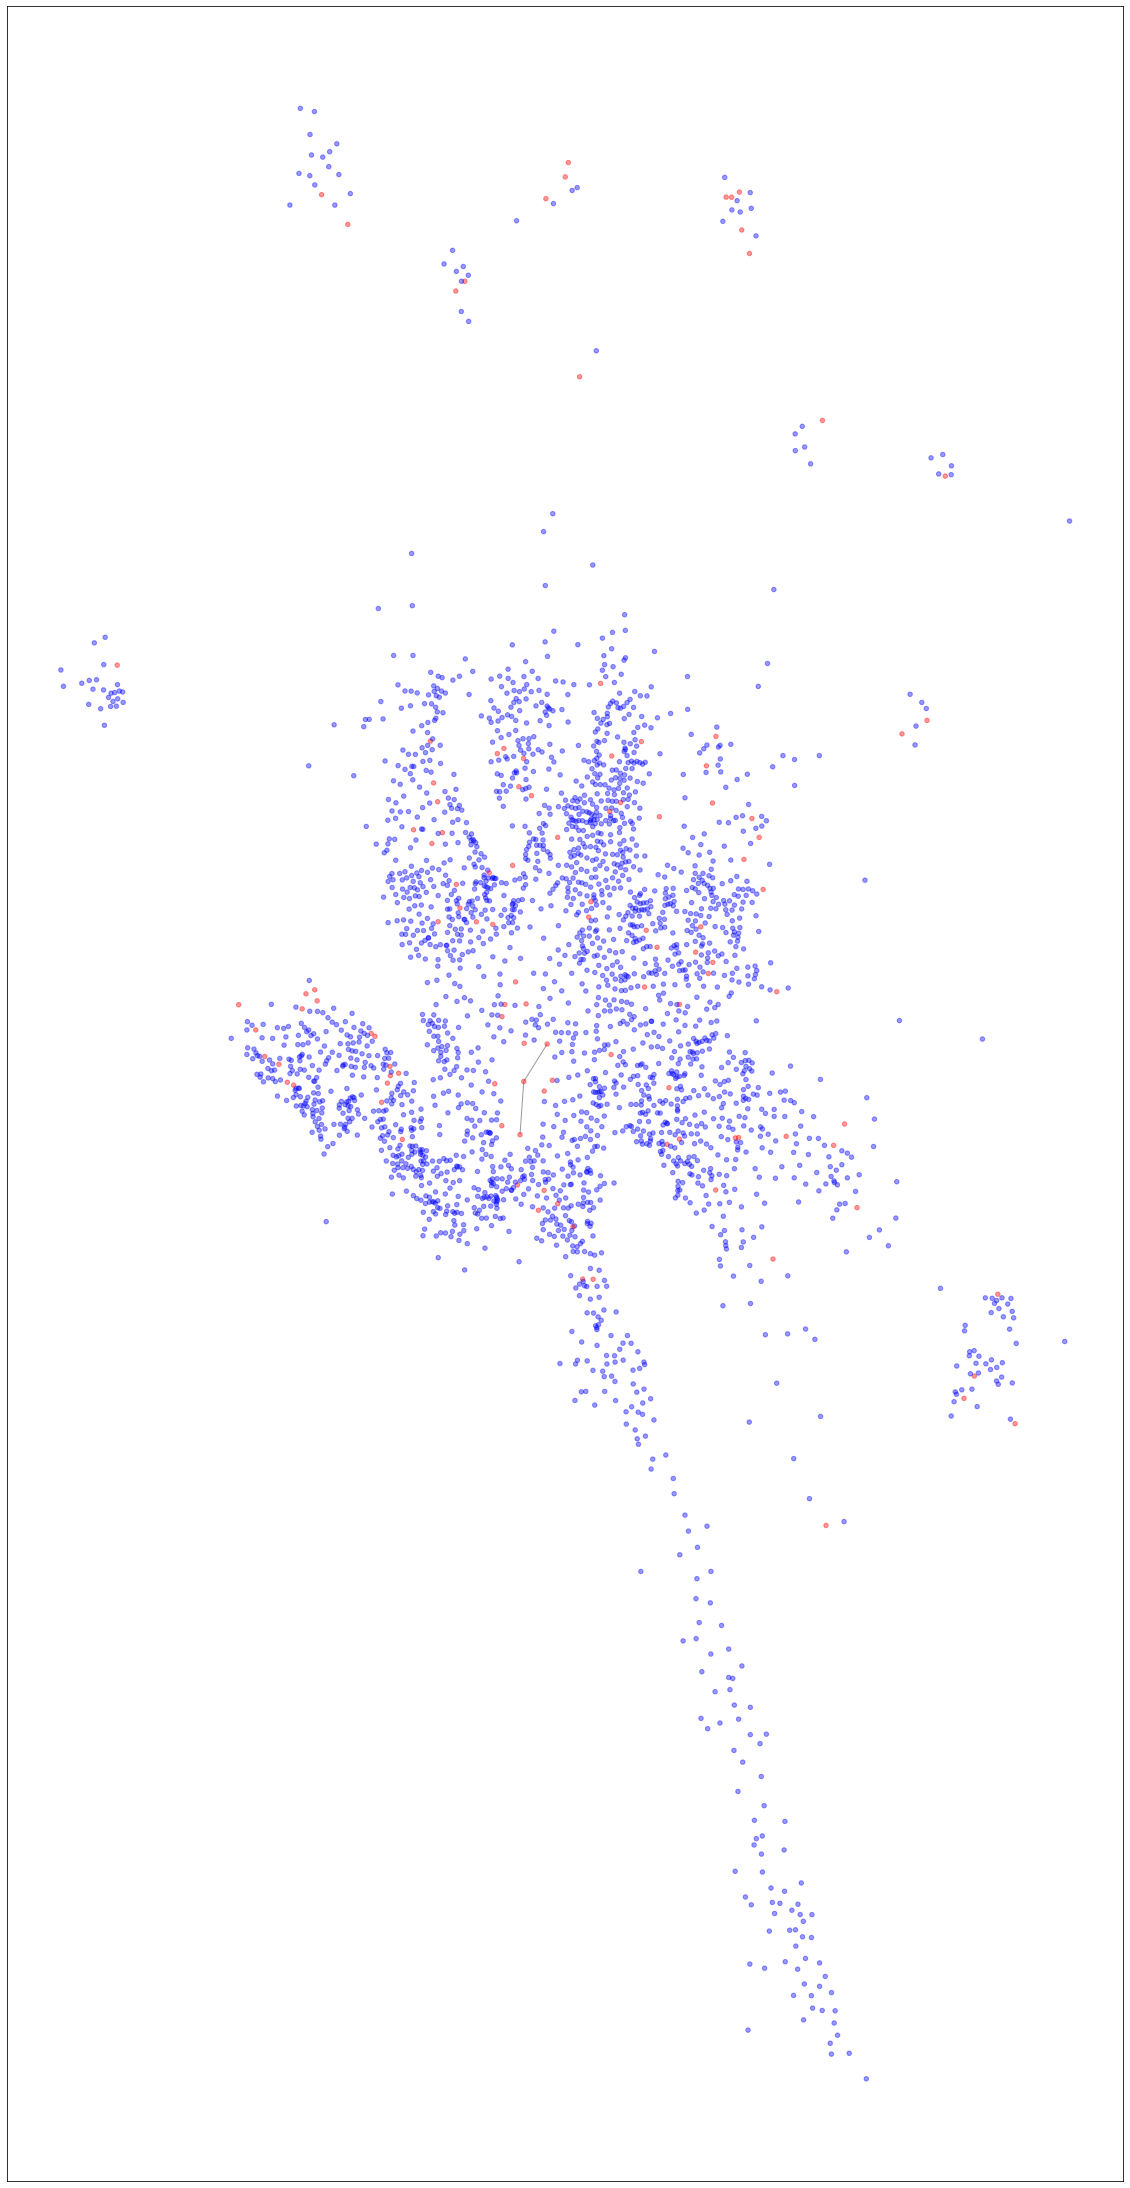

In [53]:
intersection, color2 = get_networks_intersection(networks[6], networks[7])
plt.figure(figsize=(20, 40))
nx.draw_networkx(intersection, pos = pos, node_color = color2, 
                     with_labels = False, node_size = 20, alpha = 0.4)
plt.show()

### Intersección 2015

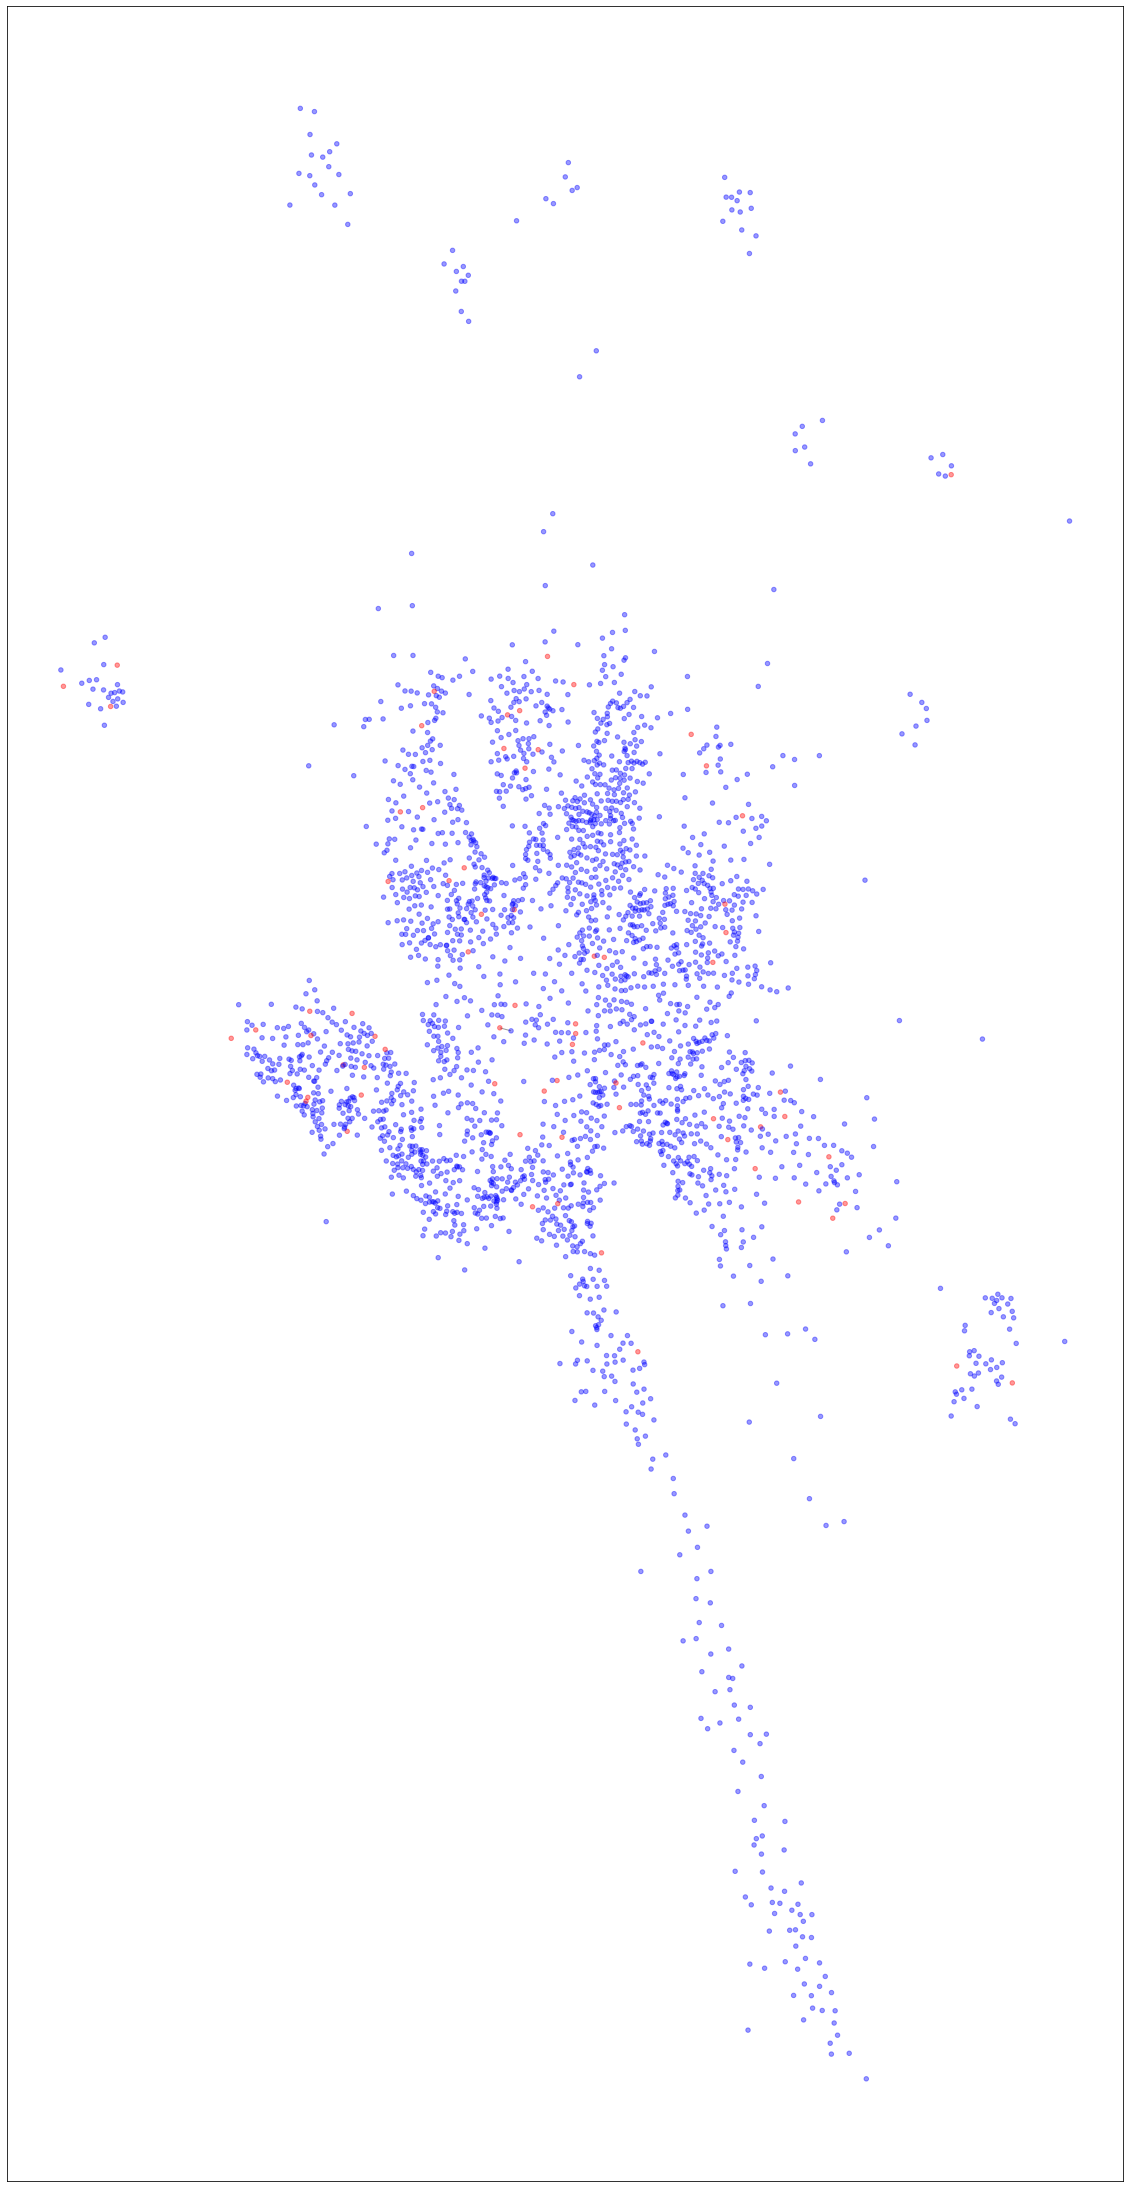

In [54]:
intersection, color2 = get_networks_intersection(networks[8], networks[9])
plt.figure(figsize=(20, 40))
nx.draw_networkx(intersection, pos = pos, node_color = color2, 
                     with_labels = False, node_size = 20, alpha = 0.4)
plt.show()

### Intersección 2016

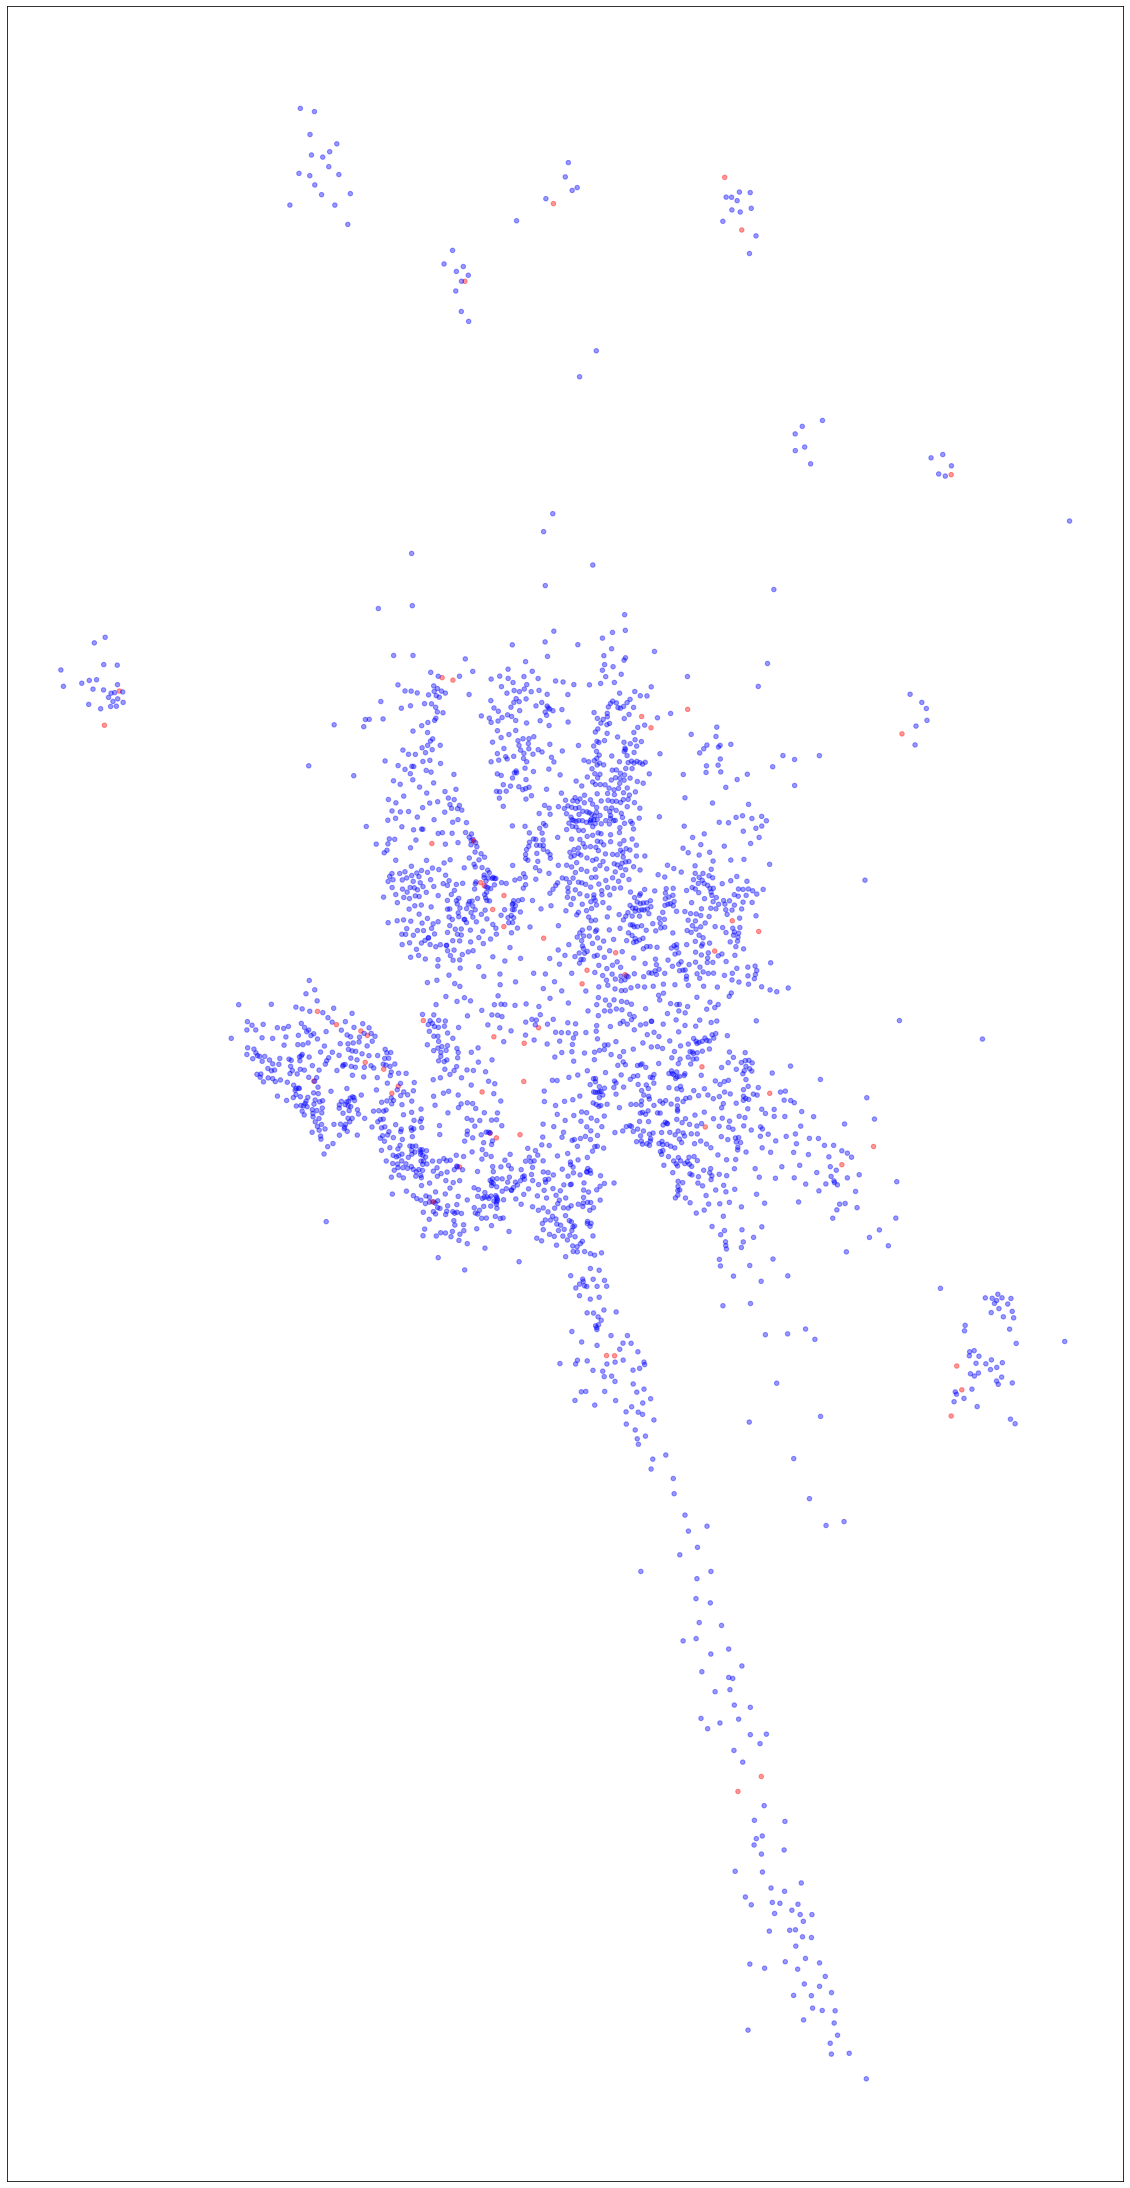

In [55]:
intersection, color2 = get_networks_intersection(networks[10], networks[11])
plt.figure(figsize=(20, 40))
nx.draw_networkx(intersection, pos = pos, node_color = color2, 
                     with_labels = False, node_size = 20, alpha = 0.4)
plt.show()

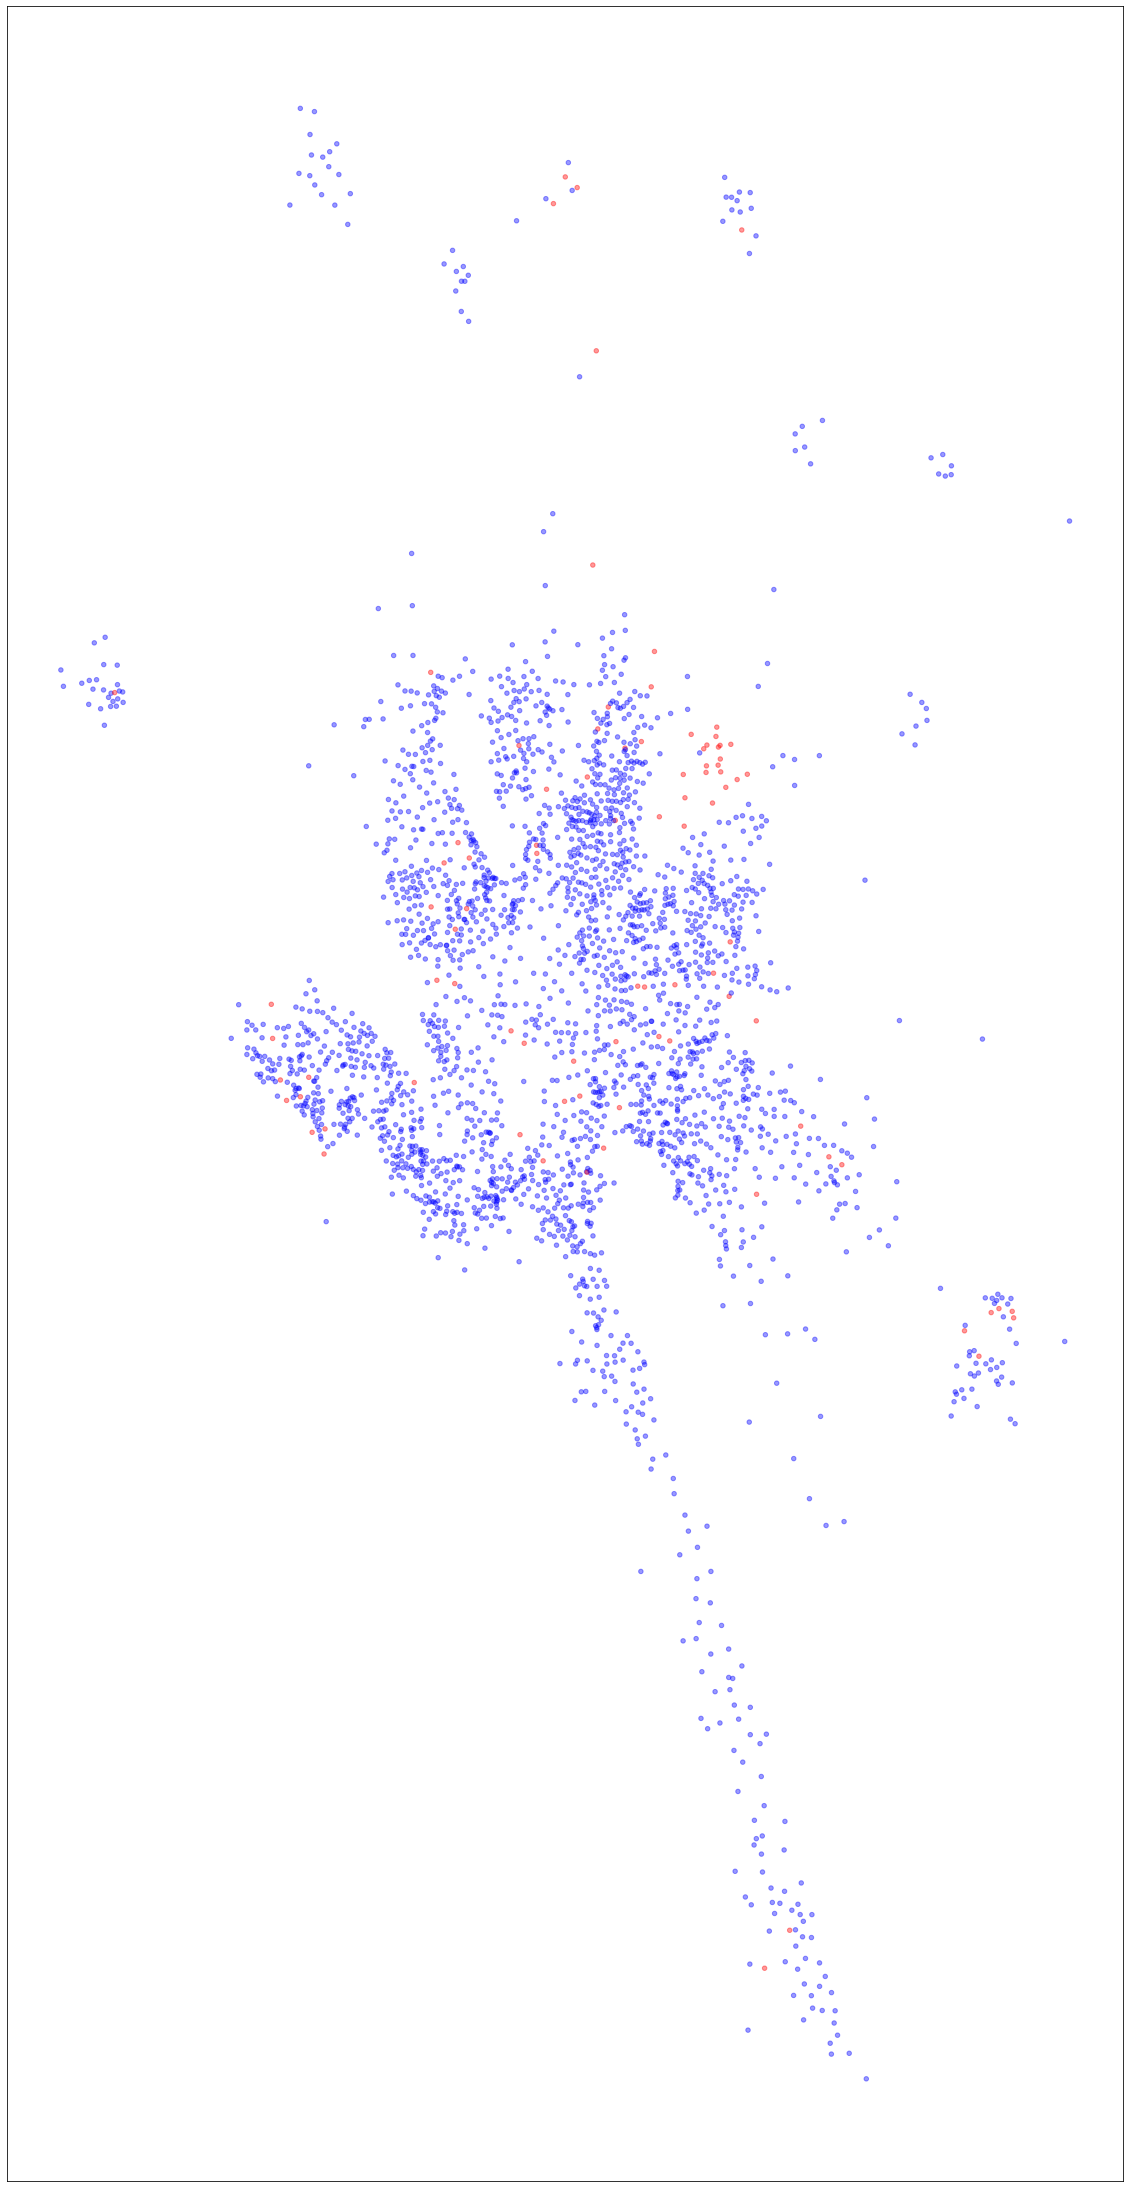

In [56]:
intersection, color2 = get_networks_intersection(networks[12], networks[13])
plt.figure(figsize=(20, 40))
nx.draw_networkx(intersection, pos = pos, node_color = color2, 
                     with_labels = False, node_size = 20, alpha = 0.4)
plt.show()